# Pars prima: SETimes dataset

Feature selection dataset - web data (as was used until now)


Training dataset - web data (as was used until now)


Hyperparameter selection dataset - train split


Evaluation dataset - dev+test split, log micro- macro-F1 and Confusion Matrices


In [17]:
from utils import transliterate, is_alpha, load_SET_dataset, load_twitter_dataset, get_N_tokens, LABELS, read_and_split_file
import pandas as pd
N = 5000

def load_tails():
    interim_dir = "/home/peterr/macocu/taskB/data/interim"
    texts, labels = list(), list()
    files = ["bswac_tail_pp", "cnrwac_tail_pp_corrected_2", "hrwac_tail_pp", "srwac_tail_pp"]
    langs = ["bs", "me", "hr", "sr"]

    for file, lang in zip(files, langs):
        full_path = os.path.join(interim_dir, file)
        current_texts = read_and_split_file(full_path)
        len_cur_texts = len(current_texts)
        texts.extend(current_texts)
        labels.extend([lang] * len_cur_texts)

    return pd.DataFrame(data={"text": texts, "labels": labels})

train = load_tails()
tokens = get_N_tokens(N=1000)
SET = load_SET_dataset().rename(columns={"language":"labels"})

dev_df = SET.loc[SET.split == "train", ["text", "labels"]]
test_df = SET.loc[SET.split != "train", ["text", "labels"]]


In [21]:
def train_clf(N=1000):
    train = load_tails()
    tokens = get_N_tokens(N=N)
    from sklearn.svm import LinearSVC
    import gc
    from sklearn.feature_extraction.text import CountVectorizer
    gc.collect()
    clf = LinearSVC(dual=False)
    vocabulary = get_N_tokens(N)
    vectorizer = CountVectorizer(vocabulary=vocabulary, lowercase=True, binary=True)
    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels
    


    clf.fit(train_vectors.toarray(), train_labels)

    return clf, vectorizer

def eval_clf(clf, eval_df, vectorizer):
    from sklearn.metrics import (
        f1_score,
        ConfusionMatrixDisplay,
        confusion_matrix,
        accuracy_score,
    )
    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels
    y_pred = clf.predict(test_vectors.toarray())
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS, average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    returndict = dict(
        N=N,
        macroF1=macro,
        microF1=micro,
        accuracy=acc,
        cm = cm,

    )
    return returndict



In [26]:
import numpy as np
Ns = np.logspace(1, 5, 100, dtype=np.int)
results = list()
for N in Ns:
    try:
        clf, vectorizer = train_clf(N=N)
        rezdict = eval_clf(clf, dev_df, vectorizer)
        rezdict["dev"] = "SET train"
        results.append(rezdict)
    except:
        pass



In [27]:
pd.DataFrame(data=results).to_csv("1_part_SETIMES_hyperparams_optimization.csv")

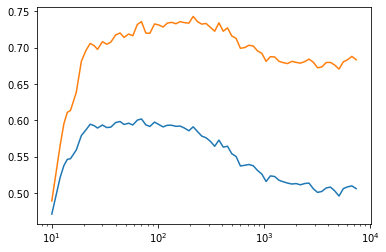

In [33]:
import matplotlib.pyplot as plt
df = pd.read_csv("1_part_SETIMES_hyperparams_optimization.csv")
plt.plot(df.N, df.macroF1, label="macro F1")
plt.plot(df.N, df.microF1, label="micro F1")
plt.semilogx()
plt.show()

In [30]:
df.columns

Index(['Unnamed: 0', 'N', 'macroF1', 'microF1', 'accuracy', 'cm', 'dev'], dtype='object')